# NPSC2002 — Workshop 2: Orbital Mechanics & Rockets

---

## Learning Objectives

By the end of this workshop you will be able to:

1. Apply Kepler's Laws to calculate orbital periods and semi-major axes for solar system bodies
2. Calculate orbital and escape velocities, and compare them across very different bodies
3. Explain why escape velocity has profound consequences for mission design
4. Use the Tsiolkovsky Rocket Equation to relate propellant mass to achievable velocity change
5. Explain why multi-stage rockets are used and quantify the benefit of staging

---

## How this workshop works

Cells marked 🔵 **YOUR TURN — Code** ask you to write or complete Python code.  
Cells marked 🟠 **YOUR TURN — Explain** ask you to write a short scientific explanation in plain English.  
Cells marked ✅ are worked examples or provided code — run them and make sure you understand them before moving on.

**You do not need to be a Python expert.** Marks are awarded primarily for scientific reasoning. If you get stuck on the code, ask for help in class or online (LLMs).

> 💾 **Save your work regularly** using **File → Save** (or Ctrl+S / Cmd+S).

In [50]:
# ✅ RUN THIS CELL FIRST — imports and constants

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# --- Astropy: physical constants and units ---
# We use astropy rather than hard-coding numbers.
# astropy.constants provides CODATA/IAU recommended values.
import astropy.units as u
from astropy.constants import G, M_earth, M_sun, R_earth, R_sun, g0

# --- Convenience: plain SI floats for use in numpy calculations ---
G_si     = G.value          # m³ kg⁻¹ s⁻²
ME_si    = M_earth.value    # kg
MS_si    = M_sun.value      # kg
RE_si    = R_earth.value    # m
g0_si    = g0.value         # m s⁻²
AU_m     = (1 * u.au).to(u.m).value   # metres per AU

print("Constants loaded from astropy:")
print(f"  G        = {G}")
print(f"  M_sun    = {M_sun:.4e}")
print(f"  M_earth  = {M_earth:.4e}")
print(f"  R_earth  = {R_earth:.4e}")
print(f"  g0       = {g0:.6f}")
print(f"  1 AU     = {AU_m:.4e} m")

Constants loaded from astropy:
  G        = 6.6743e-11 m3 / (kg s2)
  M_sun    = 1.9884e+30 kg
  M_earth  = 5.9722e+24 kg
  R_earth  = 6.3781e+06 m
  g0       = 9.806650 m / s2
  1 AU     = 1.4960e+11 m


---
# Part 1 — Orbital Mechanics (~60 minutes)

Why do spacecraft stay in orbit rather than falling straight down? An orbit is simply **continuous free-fall around a body**. The spacecraft is always falling toward Earth, but Earth's surface curves away beneath it at the same rate. Newton realised that a cannonball fired fast enough horizontally would never reach the ground — it would fall *around* the planet indefinitely.

The mathematical description was established by Johannes Kepler from painstaking observations in the early 1600s, decades before Newton developed the gravitational theory to explain *why* orbits take the shapes they do.

## 1.1 Kepler's Laws

**Kepler's First Law:** Orbits are ellipses with the central body at one *focus*. A circle is a special case.

**Kepler's Second Law:** A line from the central body to the orbiting object sweeps equal areas in equal times — objects move *faster* near the central body and *slower* far away.

**Kepler's Third Law:** The square of the orbital period $T$ is proportional to the cube of the semi-major axis $a$:

$$T^2 = \frac{4\pi^2}{GM}\,a^3 \qquad\Longleftrightarrow\qquad T = 2\pi\sqrt{\frac{a^3}{GM}}$$

Solving for $a$ instead:

$$a = \left(\frac{GMT^2}{4\pi^2}\right)^{1/3}$$

> **Semi-major axis $a$:** For a circular orbit, $a$ is simply the orbital radius. For an ellipse, $a$ is the average of the closest (periapsis) and furthest (apoapsis) distances.

In [51]:
# ✅ WORKED EXAMPLE — Verify Earth's orbital period at 1 AU

a_earth_m = 1 * AU_m    # metres

T_s = 2 * np.pi * np.sqrt(a_earth_m**3 / (G_si * MS_si))  # seconds
T_d = T_s / 86400                                           # days
T_yr = T_d / 365

print(f"Earth's orbital period from Kepler's Third Law:")
print(f"  {T_s:.3e} s  =  {T_d:.1f} days")
print(f"  Expected: 365.25 days ✓")
print(f"  Expected: {T_yr:.3} years ✓")

Earth's orbital period from Kepler's Third Law:
  3.156e+07 s  =  365.3 days
  Expected: 365.25 days ✓
  Expected: 1.0 years ✓


### Activity 1.1 — Orbital periods of the solar system

A pandas DataFrame containing the solar system bodies is provided below. Your task is to add an orbital period column.

🔵 **YOUR TURN — Code**

1. Convert the `a_AU` column from AU to metres.
2. Apply Kepler's Third Law (orbiting the Sun) to compute `T_yr` — the orbital period in years — for each body.
3. Add `T_yr` to the DataFrame and print it.

*Tip: you can operate on the whole `a_AU` column as a numpy array — no loop needed.*

In [52]:
# ✅ Solar system DataFrame, ordered by distance from the Sun.

solar_system = pd.DataFrame({
    'body':  ['Mercury','Venus',  'Earth','Mars',   'Ceres',
              'Jupiter','Saturn', 'Uranus','Neptune','Pluto'],
    'a_AU':  [0.387,    0.723,    1.000,   1.524,    2.768,
              5.203,    9.537,    19.19,   30.07,    39.48],
    'type':  ['planet', 'planet', 'planet','planet', 'dwarf planet',
              'planet', 'planet', 'planet','planet', 'dwarf planet']
})

# Convert AU to metres
solar_system['a_m'] = solar_system['a_AU'] * (1 * u.au).to(u.m).value

# 🔵 YOUR TURN: fill in the formula for orbital period (in seconds) using Kepler's Third Law.
#   T = 2π √(a³ / GM)   where M is the mass of the Sun.
solar_system['T_yr'] = (2 * np.pi * np.sqrt(solar_system['a_m']**3/ (G_si * M_sun)) / (86400*365))

solar_system


,body,a_AU,type,a_m,T_yr
0,Mercury,0.387,planet,5.789438e+10,0.240920
1,Venus,0.723,planet,1.081593e+11,0.615195
2,Earth,1.000,planet,1.495979e+11,1.000704
3,Mars,1.524,planet,2.279872e+11,1.882708
4,Ceres,2.768,dwarf planet,4.140869e+11,4.608448
5,Jupiter,5.203,planet,7.783577e+11,11.876441
6,Saturn,9.537,planet,1.426715e+12,29.472925
7,Uranus,19.190,planet,2.870783e+12,84.123634
8,Neptune,30.070,planet,4.498408e+12,165.008268
9,Pluto,39.480,dwarf planet,5.906124e+12,248.239723


🟠 **YOUR TURN — Explain**

1. Describe the relationship between orbital distance and period. Is it linear, faster than linear, or slower?

✏️ *Write your explanation here (double-click to edit)*

1. As seen in keplers third law, the orbital distance and period of a orbiting planet have a directly proportional relationship. This meaning that plantes orbiting at greater distances will have a greater orbital period.


### Activity 1.2 — Visualising Kepler's Third Law

The law predicts $T \propto a^{3/2}$. On a log-log plot, that relationship must appear as a straight line with slope 1.5.

🔵 **YOUR TURN — Code**

1. Plot $a$ (AU) vs $T$ (years) on log-log axes. Use different markers for planets and dwarf planets, and annotate each point with the body name.
2. Overplot the theoretical line $T = a^{3/2}$ as a dashed line.
3. Add axis labels and a title.

*Hint: `ax.set_xscale('log')`, `ax.set_yscale('log')`. Use `ax.annotate()` for labels.*

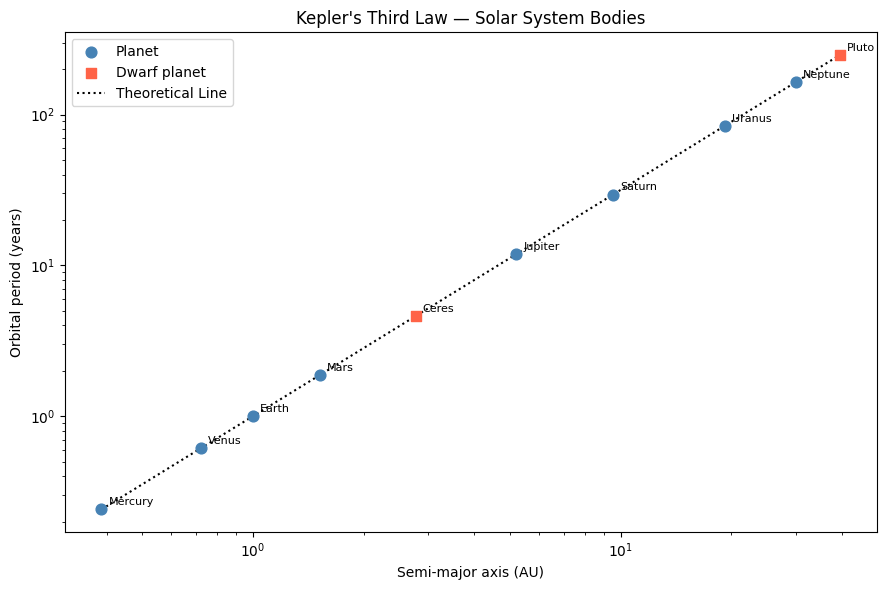

In [53]:
# ✅ Log-log plot of orbital period vs semi-major axis.
# Most of the code is provided — run it, then answer the question below.

fig, ax = plt.subplots(figsize=(9, 6))

planets = solar_system[solar_system['type'] == 'planet']
dwarfs  = solar_system[solar_system['type'] == 'dwarf planet']

ax.scatter(planets['a_AU'], planets['T_yr'], s=60, zorder=5, label='Planet',       color='steelblue')
ax.scatter(dwarfs['a_AU'],  dwarfs['T_yr'],  s=60, zorder=5, label='Dwarf planet', color='tomato', marker='s')

for _, row in solar_system.iterrows():
    ax.annotate(row['body'], (row['a_AU'], row['T_yr']),
                textcoords='offset points', xytext=(5, 3), fontsize=8)

# 🔵 YOUR TURN: add the theoretical line T = a^(3/2) as a black dashed line.

y_theoretical = solar_system['a_AU']**1.5
plt.plot(solar_system['a_AU'], y_theoretical, 'k:', label='Theoretical Line')

a_range = np.logspace(-0.5, 1.7, 200)
# Hint: plot a_range vs a_range**1.5

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Semi-major axis (AU)')
ax.set_ylabel('Orbital period (years)')
ax.set_title("Kepler's Third Law — Solar System Bodies")
ax.legend()
plt.tight_layout()
plt.show()


### Activity 1.3 — Visualising real orbits

A `plot_orbit()` helper function is provided below. It takes standard Keplerian orbital
elements and draws the orbit as a parametric curve — an ellipse in 2D with the central
body at one focus. This is exactly what an orbit *is* geometrically, so there is nothing
mysterious about the implementation: it just evaluates the polar equation of an ellipse
at many angles and converts to Cartesian coordinates.

$$r(\theta) = \frac{a(1-e^2)}{1 + e\cos\theta}$$

where $a$ is the semi-major axis, $e$ the eccentricity, and $\theta$ the true anomaly.

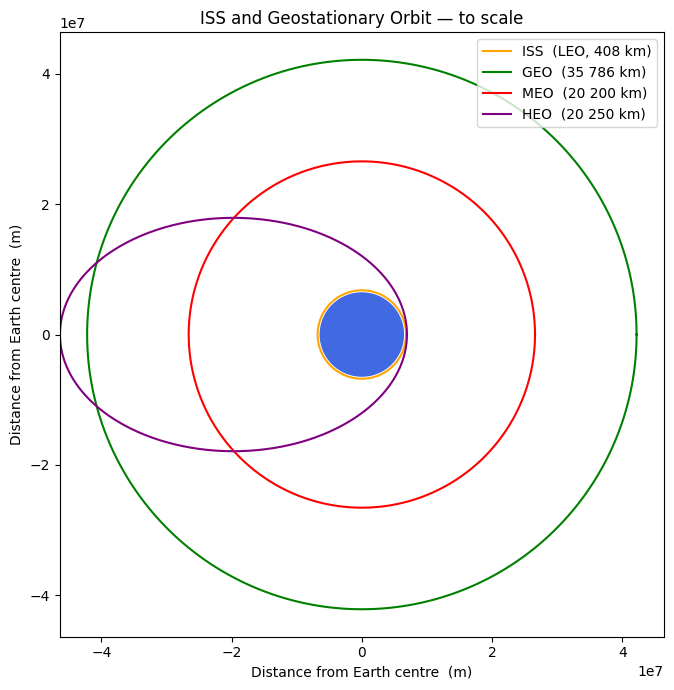

ISS period : 92.7 min
GEO period : 23.93 hr  (should be ~24 hr)


In [54]:
# ✅ WORKED EXAMPLE — orbit plotting helper and ISS + GEO plot

def plot_orbit(ax, a_m, ecc=0.0, label='', color=None, lw=1.5, n_points=500):
    """
    Draw a Keplerian orbit (in the orbital plane) on a matplotlib Axes.

    This is a 2-D plot — inclination and node angles are ignored, so all
    orbits appear in the same plane. That is fine for comparing sizes.

    Parameters
    ----------
    ax      : matplotlib Axes  (must have equal aspect ratio set)
    a_m     : float  semi-major axis [m]
    ecc     : float  eccentricity (0 = circle, 0 < e < 1 = ellipse)
    label   : str    legend label
    color   : colour passed to matplotlib
    lw      : float  line width
    n_points: int    number of points around the orbit
    """
    theta = np.linspace(0, 2 * np.pi, n_points)
    r = a_m * (1 - ecc**2) / (1 + ecc * np.cos(theta))   # polar equation of an ellipse
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    ax.plot(x, y, color=color, lw=lw, label=label)


# --- Plot ISS (LEO) and GEO ---
r_iss = RE_si + 408e3       # ISS orbital radius from Earth's centre [m]
r_geo = RE_si + 35_786e3    # GEO orbital radius [m]
r_meo = RE_si + 20_200e3
r_heo = RE_si + (40_000e3+500e3)/2
e_heo = (40000-500)/(40000+500)
e_heo = 0.74

fig, ax = plt.subplots(figsize=(7, 7))
ax.set_aspect('equal')

# Earth (filled circle at centre)
earth_patch = plt.Circle((0, 0), RE_si, color='royalblue', zorder=5)
ax.add_patch(earth_patch)

plot_orbit(ax, r_iss, ecc=0.0, label='ISS  (LEO, 408 km)',  color='orange')
plot_orbit(ax, r_geo, ecc=0.0, label='GEO  (35 786 km)',    color='green')
plot_orbit(ax, r_meo, ecc=0.0, label='MEO  (20 200 km)',    color='red')
plot_orbit(ax, r_heo, ecc=e_heo, label='HEO  (20 250 km)',    color='purple')

lim = r_geo * 1.1
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_xlabel('Distance from Earth centre  (m)')
ax.set_ylabel('Distance from Earth centre  (m)')
ax.set_title('ISS and Geostationary Orbit — to scale')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Print periods using Kepler's Third Law
T_iss = 2 * np.pi * np.sqrt(r_iss**3 / (G_si * ME_si))
T_geo = 2 * np.pi * np.sqrt(r_geo**3 / (G_si * ME_si))
print(f"ISS period : {T_iss/60:.1f} min")
print(f"GEO period : {T_geo/3600:.2f} hr  (should be ~24 hr)")

🔵 **YOUR TURN — Code**

Using `plot_orbit()`, create a single diagram showing all four major Earth orbit regimes:

| Regime | Representative altitude | Eccentricity | Example use |
|--------|------------------------|-------------|-------------|
| LEO | 408 km | 0 | ISS |
| MEO | 20 200 km | 0 | GPS / Galileo |
| GEO | 35 786 km | 0 | Weather / comms |
| HEO (Molniya) | periapsis 500 km, apoapsis 40 000 km | ~0.74 | High-latitude comms |

Add the two missing orbit regimes in the previous coding cell.

For the HEO, calculate the semi-major axis and eccentricity from the periapsis and apoapsis distances:

$$a = \frac{r_{\text{peri}} + r_{\text{apo}}}{2}$$

$$e = \frac{r_{\text{apo}} - r_{\text{peri}}}{r_{\text{apo}} + r_{\text{peri}}}$$

*Include Earth as a filled circle at the centre. Set the plot limits to just beyond GEO.*

🟠 **YOUR TURN — Explain**

1. Comment on the relative sizes of these orbit regimes.
2. A satellite TV dish always points at a fixed spot in the sky. Which orbit type makes this possible, and why?
3. Why can't a geostationary satellite provide coverage over the poles?

✏️ *Write your explanation here*

1. LEO, MEO and GEO all have circular, symetrical orbit regimes due to having an eccentricity of 0, while HEO has an eccentricity of 0.74, resulting in a stretched/elongated orbit regime.

2. LEO, MEO and Geo due to their symetric, circular orbital regime.

3. Because geostationry satellites have zero inclination and orbit directly above the equator.

---
## 1.2 Orbital Velocity and Escape Velocity

For a **circular orbit**, gravity provides exactly the centripetal force needed:

$$\frac{GMm}{r^2} = \frac{mv_{\text{orbit}}^2}{r} \quad\Rightarrow\quad
  \boxed{v_{\text{orbit}} = \sqrt{\frac{GM}{r}}}$$

**Escape velocity** is the minimum speed to permanently escape a body's gravity (arriving at infinity with zero speed remaining). From energy conservation:

$$\boxed{v_{\text{escape}} = \sqrt{\frac{2GM}{r}} = \sqrt{2}\;v_{\text{orbit}}}$$

A beautiful result: *escape velocity is always $\sqrt{2} \approx 1.414$ times the local circular orbital speed*, regardless of the body or altitude. To escape from a circular orbit, you need to increase your speed by only 41%. That sounds modest — but the consequences are enormous when propellant masses are involved.

In [55]:
# ✅ WORKED EXAMPLE — orbital and escape velocity at Earth's surface and ISS altitude

for label, r in [('Earth surface     ', RE_si),
                 ('ISS altitude 408 km', RE_si + 408e3)]:
    v_orb = np.sqrt(G_si * ME_si / r)
    v_esc = np.sqrt(2) * v_orb
    print(f"{label}:  v_orbit = {v_orb/1e3:.2f} km/s    v_escape = {v_esc/1e3:.2f} km/s")

Earth surface     :  v_orbit = 7.91 km/s    v_escape = 11.18 km/s
ISS altitude 408 km:  v_orbit = 7.66 km/s    v_escape = 10.84 km/s


### Activity 1.4 — Escape velocity across the solar system

Escape velocity depends on both mass and radius. The same formula that applies to planets
applies equally to moons and tiny asteroids — but the numbers are wildly different.

The table below includes most solar system bodies, but the **Sun is missing**.

🔵 **YOUR TURN — Code**

The Sun's mass and radius are already imported as `M_sun` and `R_sun` from astropy.  
Find their SI values (use `.value`) and fill in the three Sun scenario rows below:

- **Sun (surface)** — escape from the Sun's photosphere
- **Sun at Earth's orbit** — escape from the Sun's gravity if you are at 1 AU (= escape the solar system from Earth's location)




In [56]:
# ✅ Solar system bodies, ordered by approximate distance from the Sun.
# Note: moons and asteroids are placed near their parent body's orbit.


data = [
    {'body': 'Mercury', 'mass_kg': 3.285e23,  'distance_m': 2.440e6, 'type': 'planet'},
    {'body': 'Venus',   'mass_kg': 4.867e24,  'distance_m': 6.051e6, 'type': 'planet'},
    {'body': 'Earth',   'mass_kg': M_earth.value, 'distance_m': R_earth.value, 'type': 'planet'},
    {'body': 'Moon',    'mass_kg': 7.342e22,  'distance_m': 1.737e6, 'type': 'moon'},
    {'body': 'Mars',    'mass_kg': 6.390e23,  'distance_m': 3.390e6, 'type': 'planet'},
    {'body': 'Vesta',   'mass_kg': 2.590e20,  'distance_m': 2.625e5, 'type': 'asteroid'},
    {'body': 'Ceres',   'mass_kg': 9.384e20,  'distance_m': 4.762e5, 'type': 'dwarf planet'},
    {'body': 'Eros',    'mass_kg': 6.687e15,  'distance_m': 8.420e3, 'type': 'asteroid'},
    {'body': 'Bennu',   'mass_kg': 7.329e10,  'distance_m': 2.450e2, 'type': 'asteroid'},
    {'body': 'Jupiter', 'mass_kg': 1.898e27,  'distance_m': 6.991e7, 'type': 'planet'},
    {'body': 'Saturn',  'mass_kg': 5.683e26,  'distance_m': 5.823e7, 'type': 'planet'},
    {'body': 'Uranus',  'mass_kg': 8.681e25,  'distance_m': 2.536e7, 'type': 'planet'},
    {'body': 'Neptune', 'mass_kg': 1.024e26,  'distance_m': 2.462e7, 'type': 'planet'},
    {'body': 'Pluto',   'mass_kg': 1.303e22,  'distance_m': 1.188e6, 'type': 'dwarf planet'},
    {'body': 'Sun Surface', 'mass_kg' : M_sun.value,  'distance_m' : R_sun.value, 'type': 'sun'},
    {'body': 'Sun Orbit', 'mass_kg' : M_sun.value,  'distance_m' : AU_m, 'type': 'sun'},
]
# 🔵 YOUR TURN: add the Suns, using 'type': 'sun'

bodies_df = pd.DataFrame.from_dict(data)

bodies_df['v_escape_kms'] = np.sqrt(2 * G_si * bodies_df['mass_kg'] / bodies_df['distance_m']) / 1e3

# 🔵 YOUR TURN: sort the table based in the escape veolocity

bodies_df

,body,mass_kg,distance_m,type,v_escape_kms
0,Mercury,3.285000e+23,2.440000e+06,planet,4.239266
1,Venus,4.867000e+24,6.051000e+06,planet,10.361794
2,Earth,5.972168e+24,6.378100e+06,planet,11.179907
3,Moon,7.342000e+22,1.737000e+06,moon,2.375336
4,Mars,6.390000e+23,3.390000e+06,planet,5.016126
5,Vesta,2.590000e+20,2.625000e+05,asteroid,0.362913
6,Ceres,9.384000e+20,4.762000e+05,dwarf planet,0.512882
7,Eros,6.687000e+15,8.420000e+03,asteroid,0.010296
8,Bennu,7.329000e+10,2.450000e+02,asteroid,0.000200
9,Jupiter,1.898000e+27,6.991000e+07,planet,60.199975



🟠 **YOUR TURN — Explain**

1. You are about to get teleported near the supermassive black hole at the centre of our galaxy.
Luckily you can choose how close you get teleported to that beast, and you also have a rocket that's good enough to escape the Earth.
Find out what is the minimum safe distance that will get you out of that tricky situation.
Answer in Astronomical Units (AU), and within an order of magnitude. Hint: add the supermassive black hole in the cell above, and try various distances.

✏️ *Write your answers here*

1.


ValueError: 'facecolor' or 'color' argument must be a valid color orsequence of colors.

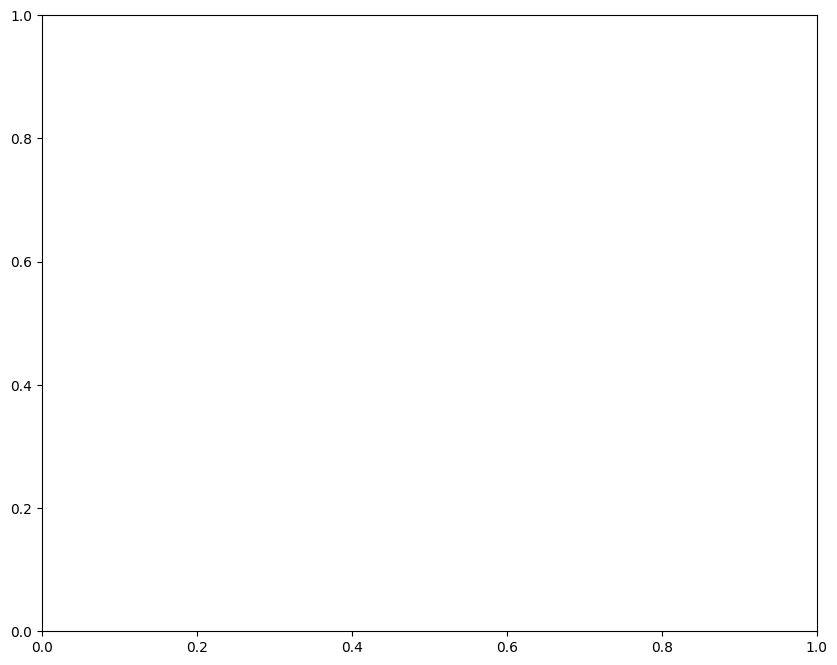

In [57]:
# ✅ Escape velocity bar chart — sorted from lowest to highest.
# The dashed line shows a typical human jump speed (~3 m/s = 0.003 km/s).

v_jump_kms = 0.003   # km/s

type_colours = {
    'star':         '#FFA500',
    'planet':       '#4C72B0',
    'moon':         '#8C8C8C',
    'dwarf planet': '#55A868',
    'asteroid':     '#C44E52'
}

plot_df = bodies_df.sort_values('v_escape_kms').reset_index(drop=True)
colours = plot_df['type'].map(type_colours)

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(plot_df['body'], plot_df['v_escape_kms'], color=colours, edgecolor='white', lw=0.5)

# Human jump speed
ax.axvline(v_jump_kms, color='black', lw=1.5, ls='--', label=f'Human jump speed  ({v_jump_kms*1e3:.0f} m/s)')

# Legend: body types + jump line
legend_patches = [mpatches.Patch(color=c, label=t.capitalize()) for t, c in type_colours.items()]
legend_patches.append(plt.Line2D([0], [0], color='black', ls='--', lw=1.5, label='Human jump speed'))
ax.legend(handles=legend_patches, loc='lower right', fontsize=9)

ax.set_xscale('log')
ax.set_xlabel('Escape velocity (km/s)')
ax.set_title('Escape Velocity Across the Solar System')
plt.tight_layout()
plt.show()


🟠 **YOUR TURN — Explain**

Use the bar chart to answer the following question.

1. Which body could you escape from by jumping? What does this mean practically for an astronaut working there?


✏️ *Write your explanation here*

1.

### Interlude — Delta-v: the universal currency of spaceflight

Before moving to rockets, we need the concept that connects orbital mechanics to propulsion: **delta-v** ($\Delta v$).

$\Delta v$ is the total change in velocity a spacecraft must execute to complete its mission. It is the single most important number in mission planning — more fundamental than thrust or travel time — because it directly determines how much propellant is needed. Every orbit change, every planet arrival, every landing and ascent has a $\Delta v$ cost that can be calculated from the orbital mechanics you have already studied.

| Mission phase | Typical $\Delta v$ (m/s) |
|---|---|
| Launch to LEO (including gravity and drag losses) | ~9 400 |
| LEO → GEO | ~4 200 |
| LEO → Trans-Lunar Injection | ~3 100 |
| Lunar orbit insertion | ~900 |
| Lunar descent and landing | ~2 000 |
| Lunar ascent | ~1 900 |
| Trans-Earth Injection | ~1 000 |
| LEO → Trans-Mars Injection | ~3 600 |
| Mars orbit insertion | ~900 |
| Powered descent to Mars surface | ~1 500 |

Notice that reaching LEO costs ~9 400 m/s even though orbital velocity is only ~7 800 m/s. The extra ~1 600 m/s is lost fighting gravity and aerodynamic drag during ascent through the atmosphere — an unavoidable tax for launching from a planet.

$\Delta v$ values for separate burns add directly, so a mission's total $\Delta v$ budget is simply the sum of all its phases. In Part 2 we will see how the rocket equation converts any $\Delta v$ budget into a propellant mass.

---
# Part 2 — Rockets (~60 minutes)

The $\Delta v$ needed to reach LEO is ~9 400 m/s. The only technology that can deliver this from a standing start on Earth is a **rocket**: a vehicle that carries both its fuel and the oxidiser needed to burn it, expelling hot exhaust rearward at high speed. Rockets are governed by conservation of momentum — every kilogram of exhaust expelled backward slightly increases the rocket's forward velocity.

Tsiolkovsky worked out the mathematics in 1903, more than 50 years before the first orbital flight.

## 2.1 The Tsiolkovsky Rocket Equation

$$\boxed{\Delta v = v_e\,\ln\!\left(\frac{m_0}{m_f}\right)}$$

| Symbol | Meaning |
|----------|---|
| $\Delta v$ | Achievable velocity change [m/s] |
| $v_e $ | Effective exhaust velocity [m/s] |
| $I_{sp}$ | Specific impulse: engineering measure of engine efficiency [s] |
| $m_0$ | Initial (wet) mass: rocket + all propellant [kg] |
| $m_f$ | Final (dry) mass: rocket after all propellant burned [kg] |

Specific impulse is defined by:
$$I_{sp} = \frac{v_e} {g_0}$$

Propellants:

| Propellant type | $I_{sp}$ (s) | Example engine |
|---|---|---|
| Solid propellant | 230–300 | Space Shuttle SRBs |
| Kerosene / LOX | 290–370 | Falcon 9 Merlin, Saturn V F-1 |
| LH₂ / LOX | 430–460 | Space Shuttle Main Engine, RL-10 |
| Ion thruster | 1 000–10 000 | Hayabusa |

Rearranging, the **propellant mass fraction** — what fraction of the initial mass must be propellant — is:

$$\frac{m_{\text{prop}}}{m_0} = 1 - e^{-\Delta v / v_e}$$

In [ ]:
# ✅ WORKED EXAMPLE — Falcon 9 first stage
# Approximate specs: Isp 311 s (sea level), wet mass 418 000 kg, dry mass 26 000 kg

Isp_F9 = 311.0
m0_F9  = 418_000.0
mf_F9  =  26_000.0

ve_F9  = Isp_F9 * g0_si
dv_F9  = ve_F9 * np.log(m0_F9 / mf_F9)

print(f"Falcon 9 first stage:")
print(f"  Exhaust velocity    : {ve_F9/1e3:.2f} km/s")
print(f"  Mass ratio m₀/mf   : {m0_F9/mf_F9:.2f}")
print(f"  Achievable Δv      : {dv_F9/1e3:.2f} km/s")
print(f"  Propellant fraction: {(m0_F9-mf_F9)/m0_F9:.1%}")

### Activity 2.1 — The Tyranny of the Rocket Equation

The propellant fraction $1 - e^{-\Delta v / v_e}$ grows *exponentially* with $\Delta v$. This is why getting to space is so difficult.


In [ ]:
# ✅ Propellant fraction function, LEO table, and tyranny plot

def propellant_fraction(dv, Isp):
    """Propellant mass fraction needed to achieve dv with given Isp."""
    ve = Isp * g0_si
    return 1 - np.exp(-dv / ve)

engines = pd.DataFrame({
    'type':  ['Solid', 'Kerosene/LOX', 'LH₂/LOX', 'Ion thruster'],
    'Isp_s': [265,      330,            445,         3000]
})
dv_LEO = 9400   # m/s

engines['prop_fraction_LEO']    = engines['Isp_s'].apply(lambda i: propellant_fraction(dv_LEO, i))
engines['payload_fraction_LEO'] = 1 - engines['prop_fraction_LEO']

print("Propellant fractions for a LEO launch (δv = 9 400 m/s):")
print(engines[['type', 'Isp_s', 'prop_fraction_LEO', 'payload_fraction_LEO']].to_string(index=False))

# --- Plot: propellant fraction vs δv ---
dv_range    = np.linspace(0, 30_000, 500)
colours_eng = ['#E69F00', '#56B4E9', '#009E73', '#CC79A7']

fig, ax = plt.subplots(figsize=(10, 6))

for (_, row), col in zip(engines.iterrows(), colours_eng):
    pf = propellant_fraction(dv_range, row['Isp_s'])
    ax.plot(dv_range, pf, color=col, lw=2, label=f"{row['type']}  (Isp={row['Isp_s']} s)")

ax.axvline(9400,  color='black', ls='--', lw=1.2, label='LEO  (9 400 m/s)')
ax.axvline(11200, color='grey',  ls=':',  lw=1.2, label='Earth escape  (11 200 m/s)')
ax.set_xlabel('Required δv  (m/s)')
ax.set_ylabel('Propellant mass fraction')
ax.set_title('The Tyranny of the Rocket Equation')
ax.set_ylim(0, 1.05)
ax.legend(fontsize=9)
plt.tight_layout()
plt.show()



🟠 **YOUR TURN — Explain**

1. For a kerosene/LOX rocket launching to LEO, what is roughly the propellant fraction?

2. What does that mean for the rocket/spacecraft assembly?

✏️ *Write your explanation here*

1.

2.


## 2.2 Multi-Stage Rockets

The key insight: once a propellant tank is empty, it is dead weight. Discarding empty stages mid-flight dramatically improves the mass ratio for subsequent burns.

For a rocket with $n$ stages, the total $\Delta v$ is the **sum** of each stage's contribution:

$$\Delta v_{\text{total}} = \sum_{i=1}^{n} v_{e,i}\,\ln\!\left(\frac{m_{0,i}}{m_{f,i}}\right)$$

The masses are measured *at the time that stage fires* — including all later stages and payload, but not the already-discarded hardware.

### Activity 2.2 — Single-stage vs two-stage to orbit

Two rocket designs share the same hardware budget:

- Total launch mass: **500 000 kg**
- Payload: **10 000 kg**
- Engine $I_{sp}$: **350 s** (kerosene/LOX)
- Structural fraction $\varepsilon$ (empty mass / stage wet mass): **0.08**

**Case A — Single Stage to Orbit (SSTO)**  
One stage burns all propellant, then must drag its empty structure all the way to orbit.

**Case B — Two equal stages**  
Propellant split equally between two stages. Stage 1 fires; when empty, it is discarded before Stage 2 ignites.

🔵 **YOUR TURN — Code**

Calculate the achievable $\Delta v$ for each design. Compare to the 9 400 m/s needed for LEO.

*Hint for stage mass breakdown:*  
If a stage has propellant mass $m_p$ and structural fraction $\varepsilon$, then the structural mass is $m_s = \varepsilon\,(m_s + m_p)$, giving $m_s = \varepsilon\,m_p / (1 - \varepsilon)$.

In [ ]:
# ✅ Single-stage vs two-stage comparison — structure provided.

m_total   = 500_000.0
m_payload =  10_000.0
Isp_s     = 350.0
eps       = 0.08          # structural fraction: empty mass / stage wet mass
ve_s      = Isp_s * g0_si
dv_target = 9_400.0       # m/s needed for LEO

# ── Case A: Single Stage to Orbit ──────────────────────────────────────
m_struct_A = eps * m_total
m_dry_A    = m_struct_A + m_payload
m_prop_A   = m_total - m_dry_A

# 🔵 YOUR TURN: calculate achievable Δv for Case A using the rocket equation.
dv_A = ???   # ve_s * log(m0 / mf)

print("Case A — Single Stage to Orbit")
print(f"  Dry mass (struct + payload) : {m_dry_A:,.0f} kg")
print(f"  Propellant mass             : {m_prop_A:,.0f} kg")
print(f"  Achievable Δv               : {dv_A:.0f} m/s")
print()

# ── Case B: Two Equal Stages ───────────────────────────────────────────
# Each stage has propellant mass m_p and structural mass m_s = eps*m_p/(1-eps)
m_prop_per_stage   = (m_total - m_payload) * (1 - eps) / 2
m_struct_per_stage = eps * m_prop_per_stage / (1 - eps)

m0_s1 = m_total
mf_s1 = m0_s1 - m_prop_per_stage        # after stage 1 burn
m0_s2 = mf_s1 - m_struct_per_stage      # stage 1 structure jettisoned
mf_s2 = m_struct_per_stage + m_payload  # after stage 2 burn

# 🔵 YOUR TURN: calculate Δv for each stage and sum them.
dv_s1 = ???
dv_s2 = ???
dv_B  = dv_s1 + dv_s2

print("Case B — Two Equal Stages")
print(f"  Stage 1 Δv : {dv_s1:.0f} m/s")
print(f"  Stage 2 Δv : {dv_s2:.0f} m/s")
print(f"  Total Δv   : {dv_B:.0f} m/s")
print(f"\nStaging gain: +{dv_B - dv_A:.0f} m/s from the same total hardware mass")


🟠 **YOUR TURN — Explain**

1. Which of the designs meets the requirement of reaching LEO?
   
2. What are the drawbacks of a multi-stage designs?

✏️ *Write your explanation here*

1.

2.

## Final Reflection - Another way of thinking of delta-V

![alt text for screen readers](https://i.sstatic.net/piNqI.png)

---
## Workshop Reflection

🟠 **YOUR TURN — Final Reflection**

1. Pick an exotic place to visit in the Solar System in the above graph (also at https://i.sstatic.net/piNqI.png), calculate how much delta-V is required to get there, and reflect on the main challenges to plan a mission there based on what you have learnt today.

✏️ *Write your reflection here*

1.


---
## Before you go

> 💾 **Save your work:** File → Save  (Ctrl+S / Cmd+S)